# Efficient Continuous Pareto Exploration in Multi-Task Learning

Source code for ICML submission #640 "Efficient Continuous Pareto Exploration in Multi-Task Learning"

This script generates Figure 5 in the paper.

# Module Importation

In [1]:
from pathlib import Path
import codecs
import gzip
import os
import urllib
import pickle
import random
from collections import OrderedDict
from itertools import product
from functools import partial
from contextlib import contextmanager
from tqdm.notebook import tqdm, trange

import cvxpy as cp
import numpy as np
import scipy.optimize
from scipy.sparse.linalg import LinearOperator, minres
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import torchvision.transforms as transforms

from common import *
from min_norm_solver import find_min_norm_element

%matplotlib inline

# Random seed fixation

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Dataset definition

In [3]:
uci_info = '''
age: label.
class of worker: Not in universe, Federal government, Local government, Never worked, Private, Self-employed-incorporated, Self-employed-not incorporated, State government, Without pay.
detailed industry recode: 0, 40, 44, 2, 43, 47, 48, 1, 11, 19, 24, 25, 32, 33, 34, 35, 36, 37, 38, 39, 4, 42, 45, 5, 15, 16, 22, 29, 31, 50, 14, 17, 18, 28, 3, 30, 41, 46, 51, 12, 13, 21, 23, 26, 6, 7, 9, 49, 27, 8, 10, 20.
detailed occupation recode: 0, 12, 31, 44, 19, 32, 10, 23, 26, 28, 29, 42, 40, 34, 14, 36, 38, 2, 20, 25, 37, 41, 27, 24, 30, 43, 33, 16, 45, 17, 35, 22, 18, 39, 3, 15, 13, 46, 8, 21, 9, 4, 6, 5, 1, 11, 7.
education: label.
wage per hour: continuous.
enroll in edu inst last wk: Not in universe, High school, College or university.
marital stat: label.
major industry code: Not in universe or children, Entertainment, Social services, Agriculture, Education, Public administration, Manufacturing-durable goods, Manufacturing-nondurable goods, Wholesale trade, Retail trade, Finance insurance and real estate, Private household services, Business and repair services, Personal services except private HH, Construction, Medical except hospital, Other professional services, Transportation, Utilities and sanitary services, Mining, Communications, Hospital services, Forestry and fisheries, Armed Forces.
major occupation code: Not in universe, Professional specialty, Other service, Farming forestry and fishing, Sales, Adm support including clerical, Protective services, Handlers equip cleaners etc , Precision production craft & repair, Technicians and related support, Machine operators assmblrs & inspctrs, Transportation and material moving, Executive admin and managerial, Private household services, Armed Forces.
race: White, Black, Other, Amer Indian Aleut or Eskimo, Asian or Pacific Islander.
hispanic origin: Mexican (Mexicano), Mexican-American, Puerto Rican, Central or South American, All other, Other Spanish, Chicano, Cuban, Do not know, NA.
sex: Female, Male.
member of a labor union: Not in universe, No, Yes.
reason for unemployment: Not in universe, Re-entrant, Job loser - on layoff, New entrant, Job leaver, Other job loser.
full or part time employment stat: Children or Armed Forces, Full-time schedules, Unemployed part- time, Not in labor force, Unemployed full-time, PT for non-econ reasons usually FT, PT for econ reasons usually PT, PT for econ reasons usually FT.
capital gains: continuous.
capital losses: continuous.
dividends from stocks: continuous.
tax filer stat: Nonfiler, Joint one under 65 & one 65+, Joint both under 65, Single, Head of household, Joint both 65+.
region of previous residence: Not in universe, South, Northeast, West, Midwest, Abroad.
state of previous residence: Not in universe, Utah, Michigan, North Carolina, North Dakota, Virginia, Vermont, Wyoming, West Virginia, Pennsylvania, Abroad, Oregon, California, Iowa, Florida, Arkansas, Texas, South Carolina, Arizona, Indiana, Tennessee, Maine, Alaska, Ohio, Montana, Nebraska, Mississippi, District of Columbia, Minnesota, Illinois, Kentucky, Delaware, Colorado, Maryland, Wisconsin, New Hampshire, Nevada, New York, Georgia, Oklahoma, New Mexico, South Dakota, Missouri, Kansas, Connecticut, Louisiana, Alabama, Massachusetts, Idaho, New Jersey.
detailed household and family stat: Child <18 never marr not in subfamily, Other Rel <18 never marr child of subfamily RP, Other Rel <18 never marr not in subfamily, Grandchild <18 never marr child of subfamily RP, Grandchild <18 never marr not in subfamily, Secondary individual, In group quarters, Child under 18 of RP of unrel subfamily, RP of unrelated subfamily, Spouse of householder, Householder, Other Rel <18 never married RP of subfamily, Grandchild <18 never marr RP of subfamily, Child <18 never marr RP of subfamily, Child <18 ever marr not in subfamily, Other Rel <18 ever marr RP of subfamily, Child <18 ever marr RP of subfamily, Nonfamily householder, Child <18 spouse of subfamily RP, Other Rel <18 spouse of subfamily RP, Other Rel <18 ever marr not in subfamily, Grandchild <18 ever marr not in subfamily, Child 18+ never marr Not in a subfamily, Grandchild 18+ never marr not in subfamily, Child 18+ ever marr RP of subfamily, Other Rel 18+ never marr not in subfamily, Child 18+ never marr RP of subfamily, Other Rel 18+ ever marr RP of subfamily, Other Rel 18+ never marr RP of subfamily, Other Rel 18+ spouse of subfamily RP, Other Rel 18+ ever marr not in subfamily, Child 18+ ever marr Not in a subfamily, Grandchild 18+ ever marr not in subfamily, Child 18+ spouse of subfamily RP, Spouse of RP of unrelated subfamily, Grandchild 18+ ever marr RP of subfamily, Grandchild 18+ never marr RP of subfamily, Grandchild 18+ spouse of subfamily RP.
detailed household summary in household: Child under 18 never married, Other relative of householder, Nonrelative of householder, Spouse of householder, Householder, Child under 18 ever married, Group Quarters- Secondary individual, Child 18 or older.
instance weight: ignore.
migration code-change in msa: Not in universe, Nonmover, MSA to MSA, NonMSA to nonMSA, MSA to nonMSA, NonMSA to MSA, Abroad to MSA, Not identifiable, Abroad to nonMSA.
migration code-change in reg: Not in universe, Nonmover, Same county, Different county same state, Different state same division, Abroad, Different region, Different division same region.
migration code-move within reg: Not in universe, Nonmover, Same county, Different county same state, Different state in West, Abroad, Different state in Midwest, Different state in South, Different state in Northeast.
live in this house 1 year ago: Not in universe under 1 year old, Yes, No.
migration prev res in sunbelt: Not in universe, Yes, No.
num persons worked for employer: continuous.
family members under 18: Both parents present, Neither parent present, Mother only present, Father only present, Not in universe.
country of birth father: Mexico, United-States, Puerto-Rico, Dominican-Republic, Jamaica, Cuba, Portugal, Nicaragua, Peru, Ecuador, Guatemala, Philippines, Canada, Columbia, El-Salvador, Japan, England, Trinadad&Tobago, Honduras, Germany, Taiwan, Outlying-U S (Guam USVI etc), India, Vietnam, China, Hong Kong, Cambodia, France, Laos, Haiti, South Korea, Iran, Greece, Italy, Poland, Thailand, Yugoslavia, Holand-Netherlands, Ireland, Scotland, Hungary, Panama.
country of birth mother: India, Mexico, United-States, Puerto-Rico, Dominican-Republic, England, Honduras, Peru, Guatemala, Columbia, El-Salvador, Philippines, France, Ecuador, Nicaragua, Cuba, Outlying-U S (Guam USVI etc), Jamaica, South Korea, China, Germany, Yugoslavia, Canada, Vietnam, Japan, Cambodia, Ireland, Laos, Haiti, Portugal, Taiwan, Holand-Netherlands, Greece, Italy, Poland, Thailand, Trinadad&Tobago, Hungary, Panama, Hong Kong, Scotland, Iran.
country of birth self: United-States, Mexico, Puerto-Rico, Peru, Canada, South Korea, India, Japan, Haiti, El-Salvador, Dominican-Republic, Portugal, Columbia, England, Thailand, Cuba, Laos, Panama, China, Germany, Vietnam, Italy, Honduras, Outlying-U S (Guam USVI etc), Hungary, Philippines, Poland, Ecuador, Iran, Guatemala, Holand-Netherlands, Taiwan, Nicaragua, France, Jamaica, Scotland, Yugoslavia, Hong Kong, Trinadad&Tobago, Greece, Cambodia, Ireland.
citizenship: Native- Born in the United States, Foreign born- Not a citizen of U S , Native- Born in Puerto Rico or U S Outlying, Native- Born abroad of American Parent(s), Foreign born- U S citizen by naturalization.
own business or self employed: 0, 2, 1.
fill inc questionnaire for veteran's admin: Not in universe, Yes, No.
veterans benefits: 0, 2, 1.
weeks worked in year: continuous.
year: 94, 95.
income: - 50000, 50000+.
'''

In [4]:
class UCI(torch.utils.data.Dataset):
    urls = [
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz',
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz'
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pth'
    test_file = 'test.pth'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.root = Path(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if train:
            self.data, self.labels = torch.load(
                self.root / self.processed_folder /self.training_file)
        else:
            self.data, self.labels = torch.load(
                self.root / self.processed_folder / self.test_file)

    def __getitem__(self, index):
        img, target = self.data[index], self.labels[index]

        return img, target

    def __len__(self):
        return len(self.data)

    def _check_exists(self):
        return (self.root / self.processed_folder / self.training_file).is_file() and \
            (self.root / self.processed_folder / self.test_file).is_file()

    def download(self):
        if self._check_exists():
            return

        # download files
        (self.root / self.raw_folder).mkdir(parents=True, exist_ok=True)
        (self.root / self.processed_folder).mkdir(parents=True, exist_ok=True)

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = self.root / self.raw_folder / filename
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(self.root / self.raw_folder / '.'.join(filename.split('.')[:-1]), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        name_dict = OrderedDict()
        property_list = []
        for line in uci_info.split('\n'):
            if not line:
                continue
            name, values = line.strip()[:-1].split(': ')
            name_dict[name] = []
            if values in ('ignore', 'label', 'continuous'):
                pp = values
            else:
                pp = 'normal'
            property_list.append(pp)

        self.uci_preprocess(self.root / self.raw_folder / 'census-income.data', name_dict, property_list)
        self.uci_preprocess(self.root / self.raw_folder / 'census-income.test', name_dict, property_list)

        for i, (name, values) in enumerate(name_dict.items()):
            value_set = list(sorted(list(set(values))))
            value_dict = dict()
            for j, value in enumerate(value_set):
                value_dict[value] = j
            name_dict[name] = value_dict

        training_set = self.uci_process(self.root / self.raw_folder / 'census-income.data', name_dict, property_list)
        test_set = self.uci_process(self.root / self.raw_folder / 'census-income.test', name_dict, property_list)

        with open(self.root / self.processed_folder / self.training_file, 'wb') as f:
            torch.save(training_set, f)
        with open(self.root / self.processed_folder / self.test_file, 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(
            tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(
            tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

    @staticmethod
    def uci_preprocess(path, name_dict, property_list):
        with open(path, 'r') as f:
            raw_data = f.readlines()
        for line in raw_data:
            if len(line.strip()) == 0:
                continue
            words = line.strip()[:-1].split(', ')
            if len(words) != 42:
                continue

            # make list
            for word, pp, (name, l) in zip(words, property_list, name_dict.items()):
                word = word.strip()
                if pp == 'continuous':
                    word = float(word)
                l.append(word)

    @staticmethod
    def uci_process(path, name_dict, property_list):
        with open(path, 'r') as f:
            raw_data = f.readlines()

        images = []
        labels = []
        for line in raw_data:
            if len(line.strip()) == 0:
                continue
            words = line.strip()[:-1].split(', ')
            if len(words) != 42:
                continue

            # make list
            image = []
            label = [None, None, None]
            for word, pp, (name, values) in zip(words, property_list, name_dict.items()):
                word = word.strip()
                if pp == 'continuous':
                    word = float(word)
                    image.append(word)
                elif pp == 'ignore':
                    continue
                elif pp == 'label':
                    if name == 'education':
                        label[1] = int(word.startswith(('Bachelors', 'Some', 'Maters', 'Asso', 'Doctorate', 'Prof')))
                    elif name == 'marital stat':
                        label[2] = int(word == 'Never married')
                    else: # age
                        label[0] = int(float(word) >= 40)
                else:
                    # normal
                    one_hot = np.zeros(len(values))
                    one_hot[values[word]] = 1
                    image.append(one_hot)

            images.append(torch.Tensor(np.hstack(image)))
            labels.append(torch.LongTensor(label))
        return images, labels

# Dataset Preparation

In [5]:
dataset = UCI(root='./UCI', train=True, download=True)

Processing...
Done!


# PyTorch initialization

- working directory
- device
- dataloader
- utilities

### Checkpoint paths

In [6]:
ckpt_root = Path('./UCI/checkpoints')
ckpt_root.mkdir(parents=True, exist_ok=True)

sgd_path = ckpt_root / 'sgd'
sgd_path.mkdir(parents=True, exist_ok=True)

mr_path = ckpt_root / 'minres'
mr_path.mkdir(parents=True, exist_ok=True)

print('Checkpoint root:', ckpt_root)
print('SGD path:       ', sgd_path)
print('MINRES path:    ', mr_path)

Checkpoint root: UCI/checkpoints
SGD path:        UCI/checkpoints/sgd
MINRES path:     UCI/checkpoints/minres


### Computating device initialization
We remove all random state.

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # use default cuda device
    import torch.backends.cudnn as cudnn  # make cuda deterministic
    cudnn.benchmark = False
    cudnn.deterministic = True
else:
    device = torch.device('cpu') # otherwise use cpu

print('Current device:', device)

Current device: cuda


### Training and test dataloader
We use batch size of 256 for both training and test side.

In [8]:
trainset = UCI('./UCI', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True, num_workers=0)

testset = UCI('./UCI', train=False, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, drop_last=False, num_workers=0)

print('Training Dataset:')
print(trainset)
print()

print('Test Dataset:')
print(testset)

Training Dataset:
Dataset UCI
    Number of datapoints: 199523
    Split: train
    Root Location: UCI
    Transforms (if any): None
    Target Transforms (if any): None

Test Dataset:
Dataset UCI
    Number of datapoints: 99762
    Split: test
    Root Location: UCI
    Transforms (if any): None
    Target Transforms (if any): None


### Utility functions
- evenly distributed weights
- top-k accuracies
- evaluation

In [9]:
def evenly_dist(num_weights, dim=3):
    return [ret for ret in product(np.linspace(0.0, 1.0, num_weights + 2), repeat=dim) \
            if round(sum(ret), 6) == 1.0 and all(r not in (0.0, 1.0) for r in ret)]

def topk_accuracies(logits, targets, ks=(1,)):
    assert logits.dim() == 2
    assert targets.dim() == 1
    assert logits.size(0) == targets.size(0)

    maxk = max(ks)
    _, pred = logits.topk(maxk, dim=1, largest=True, sorted=True)
    targets = targets.unsqueeze(1).expand_as(pred)
    correct = pred.eq(targets).float()

    accu_list = []
    for k in ks:
        accu = correct[:, :k].sum(1).mean()
        accu_list.append(accu.item())
    return accu_list

def evaluate(network, dataloader, closures, topk_closures):
    num_samples = 0
    total_losses = np.zeros(len(closures))
    total_top1s = np.zeros(len(closures))
    with torch.no_grad():
        network.train(False)
        for images, targets in dataloader:
            batch_size = len(images)
            num_samples += batch_size
            images = images.to(device)
            targets = targets.to(device)
            logits = network(images)
            losses = [c(network, logits, targets).item() for c in closures]
            total_losses += batch_size * np.array(losses)
            topks = [c(network, logits, targets) for c in topk_closures]
            total_top1s += batch_size * np.array(topks)
    total_losses /= num_samples
    total_top1s /= num_samples
    return total_losses, total_top1s

print('Example of evenly_dist(num_weights=5, dim=3):')
for i, combination in enumerate(evenly_dist(5, dim=3)):
    print('{:d}: ('.format(i + 1) + ', '.join(['{:.3f}'.format(digit) for digit in combination]) + ')')

Example of evenly_dist(num_weights=5, dim=3):
1: (0.167, 0.167, 0.667)
2: (0.167, 0.333, 0.500)
3: (0.167, 0.500, 0.333)
4: (0.167, 0.667, 0.167)
5: (0.333, 0.167, 0.500)
6: (0.333, 0.333, 0.333)
7: (0.333, 0.500, 0.167)
8: (0.500, 0.167, 0.333)
9: (0.500, 0.333, 0.167)
10: (0.667, 0.167, 0.167)


# Empirical Pareto front generation

- hyper-parameters
- network
- loss function
- optimizer
- learning rate scheduler
- inital state snapshot

### Hyper-Parameters declaration
- num of epochs
- num of different weight combinations

In [10]:
num_epochs = 30
num_weights = 5

### Network definition

We use a double-layer MLP with a fully-connected layer for each task.

In [11]:
class MLP(nn.Module):
    def __init__(self, **kwargs):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(487, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_age = nn.Linear(128, 2)
        self.fc_education = nn.Linear(128, 2)
        self.fc_marriage = nn.Linear(128, 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return [self.fc_age(x), self.fc_education(x), self.fc_marriage(x)]

network = MLP()
network.to(device)

print('Network:')
print(network)

Network:
MLP(
  (fc1): Linear(in_features=487, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc_age): Linear(in_features=128, out_features=2, bias=True)
  (fc_education): Linear(in_features=128, out_features=2, bias=True)
  (fc_marriage): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU(inplace=True)
)


### Loss function definition
We use cross entropy loss for two tasks.

In [12]:
criterion = nn.CrossEntropyLoss().to(device)

closures = [
    lambda n, l, t: criterion(l[0], t[:, 0]),
    lambda n, l, t: criterion(l[1], t[:, 1]),
    lambda n, l, t: criterion(l[2], t[:, 2])
]

top1_closures = [
    lambda n, l, t: topk_accuracies(l[0], t[:, 0], ks=(1,))[0],
    lambda n, l, t: topk_accuracies(l[1], t[:, 1], ks=(1,))[0],
    lambda n, l, t: topk_accuracies(l[2], t[:, 2], ks=(1,))[0]
]

### Optimizer definition
We use SGD with learning rate of 0.001 and momentum of 0.9.

In [13]:
optimizer = SGD(network.parameters(), lr=0.001, momentum=0.9)

print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Learning rate scheduler definition
We use cosine annealing learning rate scheduler for training.

In [14]:
lr_scheduler = CosineAnnealingLR(optimizer, num_epochs * len(trainloader))

### Snapshot for inital states

The initial weights/optimizer/lr_scheduler are saved for further training (we removed **ALL** randomness).

In [15]:
init_ckpt = {
    'state_dict': network.state_dict(),
    'optimizer': optimizer.state_dict(),
    'lr_scheduler': lr_scheduler.state_dict()
}
torch.save(init_ckpt, sgd_path / 'init.pth')

# Let's train it!

In [16]:
for i, weight in enumerate(tqdm(evenly_dist(num_weights, 3), desc='Weight', leave=False)):
    init_ckpt = torch.load(sgd_path / 'init.pth', map_location='cpu')  # load init snapshot
    network.load_state_dict(init_ckpt['state_dict'])
    optimizer.load_state_dict(init_ckpt['optimizer'])
    lr_scheduler.load_state_dict(init_ckpt['lr_scheduler'])
    with trange(num_epochs, desc='Epoch') as epoch_iter:
        for epoch in epoch_iter:
            network.train(True)
            for images, targets in tqdm(trainloader, desc='Batch', leave=False):
                images = images.to(device)
                targets = targets.to(device)
                logits = network(images)
                losses = [c(network, logits, targets) for c in closures]
                loss = sum(w * l for w, l in zip(weight, losses))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            eval_losses, eval_top1s = evaluate(network, testloader, closures, top1_closures)
            epoch_iter.set_postfix(**{'acc-{:d}'.format(i + 1): top for i, top in enumerate(eval_top1s)})
    ckpt = {
        'state_dict': network.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'metrics': [eval_losses, eval_top1s]
    }
    torch.save(ckpt, sgd_path / '{:d}.pth'.format(i))

# SGD results illustration

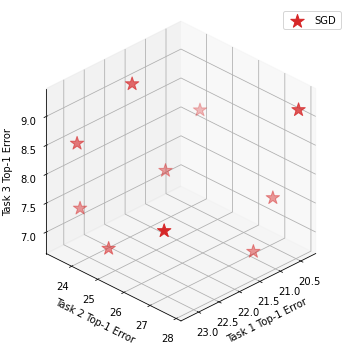

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='3d', proj_type='ortho'))
total_top1s = []
for i, weight in enumerate(evenly_dist(num_weights, 3)):
    ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
    losses, top1s = ckpt['metrics']
    total_top1s.append(top1s)
total_err1s = 100.0 * (1.0 - np.stack(total_top1s, axis=0).T)
ax.scatter(*total_err1s, color='tab:red', marker='*', s=200, label='SGD')
ax.set_xlabel('Task 1 Top-1 Error')
ax.set_ylabel('Task 2 Top-1 Error')
ax.set_zlabel('Task 3 Top-1 Error')
ax.legend()
ax.view_init(30, 45)
fig.tight_layout()
plt.show()

# MINRES initalization
- hyper-parameters
- dataloader
- optimizer
- Jacobian solver
- linear operator
- utilities

### Hyper-Parameters declaration
- num of steps
- damping for linear solver
- maxiter for MINRES
- momentum for Jacobians and alpha

In [18]:
num_steps = 20
damping = 0.1
maxiter = 100
momentum = 0.9

### Dataloader definition

We explore based on 2048 data samples.

In [19]:
mr_dataloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True, drop_last=True, num_workers=0)

### Optimizer definition
We use SGD with learning rate of 0.01 (**without** momentum for fair)

In [20]:
mr_optimizer = SGD(network.parameters(), lr=0.01)

print(mr_optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Jacobians solver definition
We iterate over trainset to solve jacobian with respect to each task.

In [21]:
jacobian_trainiter = iter(trainloader)
def compute_jacobians(ratio=1.0):
    global jacobian_trainiter
    num_batches = int(len(trainloader) * ratio)
    jacobians = None
    for _ in range(num_batches):
        try:
            images, targets = next(jacobian_trainiter)
        except StopIteration:
            jacobian_trainiter = iter(trainloader)
            images, targets = next(jacobian_trainiter)
        images = images.to(device)
        targets = targets.to(device)
        logits = network(images)
        losses = [c(network, logits, targets) for c in closures]
        param_grads = [list(torch.autograd.grad(
            l, network.parameters(), allow_unused=True,
            retain_graph=True, create_graph=False)) for l in losses]
        for param_grad in param_grads:
            for i, (param_grad_module, param) in enumerate(zip(param_grad, network.parameters())):
                if param_grad_module is None:
                    param_grad[i] = torch.zeros_like(param)
        sub_jacobians = torch.stack([parameters_to_vector(param_grad) for param_grad in param_grads], dim=0)
        sub_jacobians.detach_()
        if jacobians is None:
            jacobians = sub_jacobians
        else:
            jacobians.add_(sub_jacobians)
    jacobians.div_(num_batches)
    return jacobians.clone().detach()

### Alpha solver definition
We solve alpha by its analytical solution.

In [22]:
def compute_alpha(jacobians):
    sol, min_norm = find_min_norm_element(jacobians)
    return sol

### Linear operator for Hessian-vector product definition
We warp Hessian-vector product into a linear operator to prevent explicit computation of Hessian.

In [23]:
class HVPLinearOperator(LinearOperator):
    def __init__(self, dataloader):
        network_size = sum(p.numel() for p in network.parameters())
        shape = (network_size, network_size)
        dtype = list(network.parameters())[0].detach().cpu().numpy().dtype

        super(HVPLinearOperator, self).__init__(dtype, shape)

        self.dataloader = dataloader
        self.dataiter = iter(dataloader)

        self.alpha_jacobians = None

    def _get_jacobians(self):
        try:
            images, targets = next(self.dataiter)
        except StopIteration:
            self.dataiter = iter(self.dataloader)
            images, targets = next(self.dataiter)
        images = images.to(device)
        targets = targets.to(device)
        logits = network(images)
        losses = [c(network, logits, targets) for c in closures]
        
        # Get jacobian with respect to each loss.
        # `allow_unused=True` to get gradient from the unused tail.
        #     It returns `None`, which will be filtered later.
        # `retain_graph=True` to retain forward information for
        #     second-time backward.
        # `create_graph=True` to create computation graph for
        #     second-order derivation.
        param_grads = [list(torch.autograd.grad(
            l, network.parameters(), allow_unused=True,
            retain_graph=True, create_graph=True)) for l in losses]

        # As metioned above, `allow_unused=True` leads to `None`s in
        #     jacobian tuple. Now we replace it with a zero tensor.
        for param_grad in param_grads:
            for i, (param_grad_module, param) in enumerate(zip(param_grad, network.parameters())):
                if param_grad_module is None:
                    param_grad[i] = torch.zeros_like(param)
                    
        return torch.stack([parameters_to_vector(param_grad) for param_grad in param_grads], dim=0)

    @contextmanager
    def init(self, alpha):
        try:
            alpha = torch.as_tensor(alpha.astype(self.dtype), device=device).view(1, -1)
            jacobians = self._get_jacobians()
            self.alpha_jacobians = alpha.matmul(jacobians).squeeze()
            yield self
        finally:
            self.alpha_jacobians = None

    def _matvec_tensor(self, tensor):

        # hvp = Hv
        #     = dot(∂^2(f) / (∂x)^2, v)
        #     = ∂/∂x(dot(v, ∂f/∂x))

        # dot = dot(v, ∂f/∂x)
        dot = self.alpha_jacobians.dot(tensor)
        
        # hvp = ∂/∂x(dot)
        param_alphas_hvps = torch.autograd.grad(dot, network.parameters(), retain_graph=True)
        alphas_hvps = parameters_to_vector([p.contiguous() for p in param_alphas_hvps])

        if damping > 0.0:
            alphas_hvps.add_(tensor, alpha=damping)
        return alphas_hvps

    def _matvec(self, x):
        """HVP matrix-vector multiplication handler.

        If self is a linear operator of shape (N, N), then this method will
        be called on a shape (N,) or (N, 1) ndarray, and should return a
        shape (N,) or (N, 1) ndarray.

        In our case, it computes alpha_hession @ x.
        """
        tensor = torch.as_tensor(x.astype(self.dtype), device=device)
        ret = self._matvec_tensor(tensor)
        return ret.detach().cpu().numpy()

### Utility functions
- assign parameter.grad from vector

In [24]:
def assign_grad(vector, normalize=True):
    if normalize:
        vector.div_(vector.norm())
    offset = 0
    for p in network.parameters():
        numel = p.numel()
        # view as to avoid deprecated pointwise semantics
        p.grad = vector[offset:offset + numel].view_as(p.data).clone()
        offset += numel

# Let's explore it!
Executing this section takes around 30 to 45 minutes depending on your GPU types. However, for the results reported in the paper and supplemental material, our training process is typically a lot faster than here because of the following reasons:

- For reproducibility, we disable randomness in this script as much as we can. Therefore, parallalism on GPUs is not fully exploited;
- We frequently evaluate and save the model inside the innermost loop, which creates a lot of overhead;
- Since the MINRES implementation is from scipy and is on CPUs, calling `HVPLinearOperator` creates a lot of CPU-GPU communication. Ideally, a GPU implementation of MINRES could completely remove this communication and expedite the training process.

In [25]:
linear_op_template = HVPLinearOperator(mr_dataloader)

In [ ]:
for i, weight in enumerate(tqdm(evenly_dist(num_weights, 3), desc='Weight', leave=False)):
    for col in trange(6, desc='Direction', leave=False):
        
        mr_weights = np.array(
            [int(w) for w in '{:0>3b}'.format(col + 1)]).astype(linear_op_template.dtype).reshape(1, -1)
        
        # load SGD starting point
        init_ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
        network.load_state_dict(init_ckpt['state_dict'])

        # initalize momentum buffer
        jacobians_buffer_tensor = compute_jacobians()
        jacobians_buffer = jacobians_buffer_tensor.clone().detach().cpu().numpy()
        alpha_buffer = compute_alpha(jacobians_buffer_tensor)
        with trange(num_steps, desc='Step', leave=False) as step_iter:
            for step in step_iter:
                network.train(False)

                # compute jacobians
                jacobians_tensor = compute_jacobians(1.0 / 4.0)
                jacobians = jacobians_tensor.clone().detach().cpu().numpy()
                jacobians_buffer *= momentum
                jacobians_buffer += (1 - momentum) * jacobians
                jacobians = jacobians_buffer.copy()

                # compute alpha
                alpha = compute_alpha(jacobians_tensor)
                alpha_buffer *= momentum
                alpha_buffer += (1 - momentum) * alpha
                alpha = alpha_buffer.copy()

                # define rhs and x0
                rhs = np.squeeze(mr_weights @ jacobians)
                x0 = jacobians.mean(axis=0)
                
                # fill jacobians alpha rhs x0 to MINRES
                with linear_op_template.init(alpha) as linear_op:
                    results = minres(linear_op, rhs, x0=x0, maxiter=maxiter)
                    d = torch.as_tensor(results[0].astype(linear_op.dtype), device=device)

                # optimize
                mr_optimizer.zero_grad()
                assign_grad(d, normalize=True)
                mr_optimizer.step()

                eval_losses, eval_top1s = evaluate(network, testloader, closures, top1_closures)
                step_iter.set_postfix(**{'acc-{:d}'.format(i + 1): top for i, top in enumerate(eval_top1s)})
                ckpt = {
                    'state_dict': network.state_dict(),
                    'optimizer': mr_optimizer.state_dict(),
                    'metrics': [eval_losses, eval_top1s]
                }
                save_path = mr_path / str(i) / str(col)
                save_path.mkdir(parents=True, exist_ok=True)
                torch.save(ckpt, save_path / '{:d}.pth'.format(step))

/opt/conda/conda-bld/pytorch_1591914886554/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection='3d', proj_type='ortho'))
cmap = plt.get_cmap('autumn', len(evenly_dist(num_weights, 3)))

total_top1s = []
for i, weight in enumerate(evenly_dist(num_weights, 3)):
    ckpt = torch.load(sgd_path / '{:d}.pth'.format(i), map_location='cpu')
    losses, top1s = ckpt['metrics']
    total_top1s.append(top1s)
total_top1s = np.stack(total_top1s, axis=0).T
top1s_min = total_top1s.min(axis=1) * 0.99
total_err1s = 100.0 * (1.0 - total_top1s)
ax.scatter(*total_err1s, color=[cmap(i) for i, w in enumerate(evenly_dist(num_weights, 3))],
           marker='*', s=200, edgecolor='black')

for i, weight in enumerate(evenly_dist(num_weights, 3)):
    total_top1s = []
    for col in range(6):
        for step in range(num_steps):
            ckpt = torch.load(mr_path / str(i) / str(col) /  '{:d}.pth'.format(step), map_location='cpu')
            losses, top1s = ckpt['metrics']
            if any(top1s < top1s_min):
                continue
            total_top1s.append(top1s)
    total_err1s = 100.0 * (1.0 - np.stack(total_top1s, axis=0).T)
    ax.scatter(*total_err1s, color=cmap(i), marker='o', s=30)

ax.set_xlabel('Task 1 Top-1 Error')
ax.set_ylabel('Task 2 Top-1 Error')
ax.set_zlabel('Task 3 Top-1 Error')
ax.grid(True)

handles, labels = [], []
handles.append(
    tuple(ax.scatter([], [], [], color=cmap(i), marker='*', s=100, edgecolor='black') for i in [3, 6, 9]))
labels.append('Start')

handles.append(
    tuple(ax.scatter([], [], [], color=cmap(i), marker='o', s=30) for i in [3, 6, 9]))
labels.append('Ours')

ax.legend(handles, labels, handler_map={tuple: HandlerTuple(None, 0)})
ax.view_init(30, 45)
fig.tight_layout()
plt.show()